<a href="https://colab.research.google.com/github/DimpleB0501/ERA1/blob/main/S5/S5_Assignment_QnA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [3]:
# Train  and test data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 199165083.80it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32259838.57it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 55960605.22it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5366346.13it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

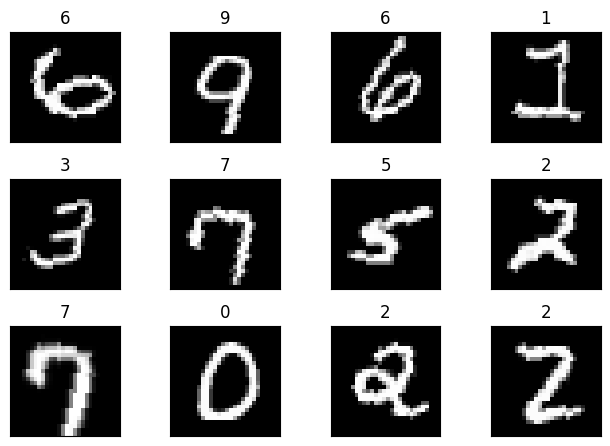

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [7]:
from google.colab import files
src = list(files.upload().values())[0]
open('model.py','wb').write(src)
import model as net

Saving model.py to model.py


In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = net.Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [10]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 10

In [11]:
model = net.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.2724 Batch_id=117 Accuracy=52.05: 100%|██████████| 118/118 [00:28<00:00,  4.15it/s]


Test set: Average loss: 0.0007, Accuracy: 53795/60000 (89.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1821 Batch_id=117 Accuracy=94.02: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Test set: Average loss: 0.0003, Accuracy: 57501/60000 (95.83%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2324 Batch_id=117 Accuracy=96.09: 100%|██████████| 118/118 [00:22<00:00,  5.34it/s]


Test set: Average loss: 0.0002, Accuracy: 57798/60000 (96.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1062 Batch_id=117 Accuracy=96.83: 100%|██████████| 118/118 [00:22<00:00,  5.25it/s]


Test set: Average loss: 0.0002, Accuracy: 58326/60000 (97.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0175 Batch_id=117 Accuracy=97.36: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0002, Accuracy: 58531/60000 (97.55%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0578 Batch_id=117 Accuracy=97.73: 100%|██████████| 118/118 [00:23<00:00,  5.13it/s]


Test set: Average loss: 0.0001, Accuracy: 58798/60000 (98.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0417 Batch_id=117 Accuracy=97.96: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


Test set: Average loss: 0.0001, Accuracy: 58921/60000 (98.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0348 Batch_id=117 Accuracy=98.15: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0001, Accuracy: 59071/60000 (98.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1051 Batch_id=117 Accuracy=98.38: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.0001, Accuracy: 58807/60000 (98.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0528 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0001, Accuracy: 58997/60000 (98.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0630 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]


Test set: Average loss: 0.0001, Accuracy: 59139/60000 (98.56%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0686 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s]


Test set: Average loss: 0.0001, Accuracy: 59289/60000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0114 Batch_id=117 Accuracy=98.71: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0001, Accuracy: 59216/60000 (98.69%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0245 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


Test set: Average loss: 0.0001, Accuracy: 59325/60000 (98.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0206 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0001, Accuracy: 59294/60000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0051 Batch_id=117 Accuracy=99.05: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0001, Accuracy: 59442/60000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0400 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.0001, Accuracy: 59477/60000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0090 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0001, Accuracy: 59472/60000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0634 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0001, Accuracy: 59516/60000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0253 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.0001, Accuracy: 59496/60000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

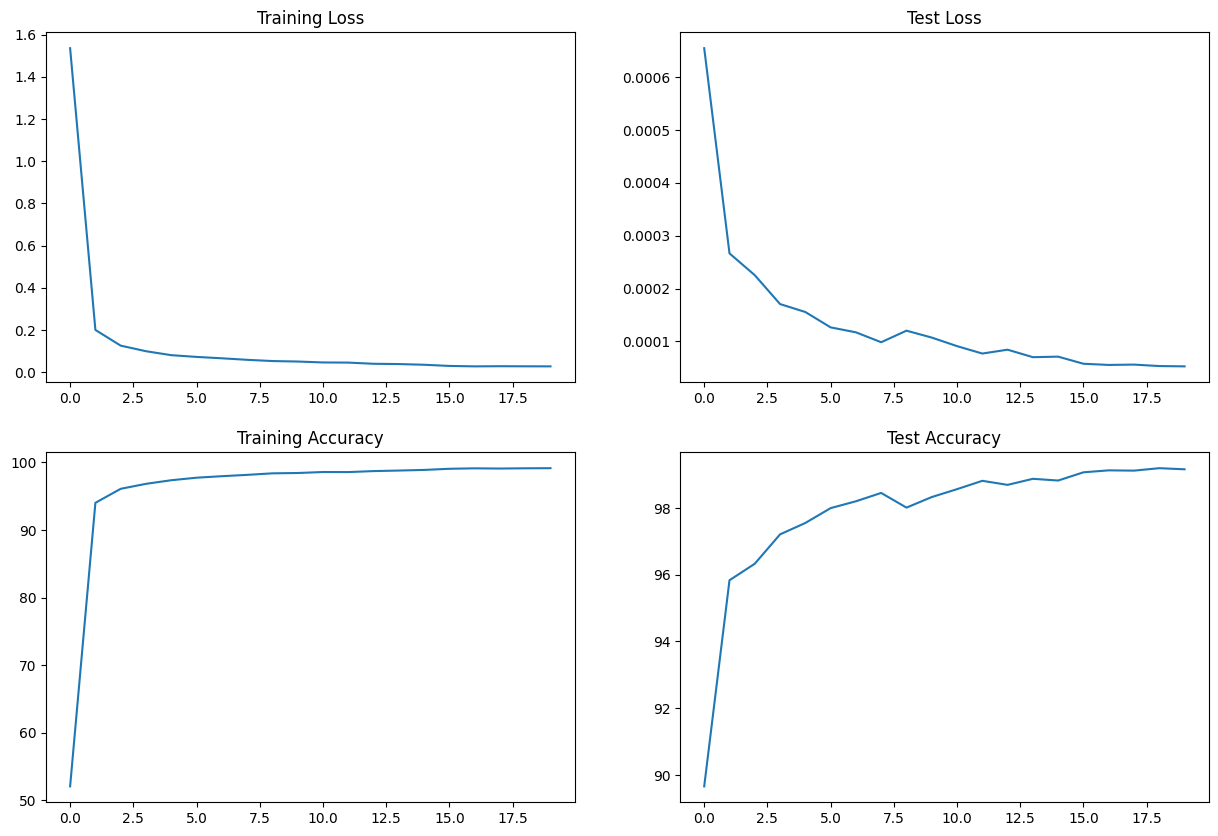

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")